In [1]:
'''
Date: 2022/Feb/9
Author: Yike Xie
Content: Combine the matrix of a few molecules together with same X and Y axis
'''

'\nDate: 2022/Feb/9\nAuthor: Yike Xie\nContent: Combine the matrix of a few molecules together with same X and Y axis\n'

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import PIL
import seaborn as sns

In [2]:
wls =np.array([
 (325, 414),
 (343, 414),#
 (370, 414),
 (343, 451),
 (370, 451),
 (373, 451),
 (343, 575),#
 (393, 575),
 (406, 575),
 (441, 575),
 (400, 594),
 (406, 594),
 (431, 594),
 (480, 594),#
 (339, 575),
])

In [3]:
def df_edit(dfs, mol, xmin, xmax, ymin, ymax):
    '''
    edit the dataframe to suit the shared x and y range
    
    args:
        dfs: the dictionary contains all the dataframes of each molecule
        mol: molecule
        a: the dataframe of mol
        xmin, xmax: the range of x axis (columns, excitation wavelength)
        ymin, ymax: the range of y axis (index, emission wavelength)
    return:
        a_new: the revised dataframe
    '''
    a = dfs[mol].copy()
    
    xi, xj = a.columns.min(), a.columns.max()
    if xmin < xi:
        a = pd.concat([a, pd.DataFrame(0, index=a.index, columns=range(xmin, int(xi + 1)))], axis=1)

    if xj < xmax:
        a = pd.concat([a, pd.DataFrame(0, index=a.index, columns=range(int(xj) + 1, xmax + 1))], axis=1)


    yi, yj = a.index.min(), a.index.max()
    if ymin < yi:
        a = pd.concat([a, pd.DataFrame(0, columns=a.columns, index=range(ymin, int(yi + 1)))], axis=0)

    if yj < ymax:
        a = pd.concat([a, pd.DataFrame(0, columns=a.columns, index=range(int(yj) + 1, ymax + 1))], axis=0)

    a = a[a.columns.sort_values()].loc[a.index.sort_values(ascending=False)]    
    a_new = a[a.columns[(a.columns >= xmin) & (a.columns <= xmax)]].loc[(a.index >= ymin) & (a.index <= ymax)]
    
    return a_new

In [9]:
# plot all the revised dataframes as well as the position of hyperspectral imaging channels
def plot_combination(mols, dfs_new, wls, name=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    rcParams['pdf.fonttype'] = 42
    axs = axs.ravel()
    plt.subplots_adjust(wspace=0.2, hspace=0.3)
    colors = sns.color_palette('hls', len(wls))
    for i, mol in enumerate(mols):
        df = dfs_new[mol]
        sns.heatmap(df, cmap='viridis', ax=axs[i])
        axs[i].set_title(mol.replace('_', ' '))

        xs, ys = [], []
        for wl in wls:
            for z, col in enumerate(df.columns[: -1]):
                if df.columns[z] <= wl[0] < df.columns[z+1]:
                    xi = z  
                    x = xi + (wl[0] - df.columns[xi]) / (df.columns[xi+1] - df.columns[xi])
                    xs.append(x)
        
            for j, idx in enumerate(df.index[: -1]):
                if df.index[j+1] < wl[1] <= df.index[j]:
                    yj = j
                    y = yj + (wl[1] - df.index[yj]) / (df.index[yj+1] - df.index[yj])
                    ys.append(y)
        axs[i].scatter(xs, ys, color=colors, s=50)

        for w in range(1, len(wls) + 1):
            axs[i].text(xs[w -1], ys[w -1], str(w), color='k', 
                        ha='center', va='center', fontsize=5)

    handles, labels = axs[-1].get_legend_handles_labels()
    for j, txt in enumerate(range(1, len(wls) + 1)):
        handles.append(axs[-1].scatter([], [], color=colors[j], s=25)) 
    axs[-1].legend(handles=handles, labels=[f'{str(u + 1)}: {str(wlu)}' for u, wlu in enumerate(wls)], 
                   bbox_to_anchor=(1.85, 1.0))

    fig.text(0.5, -.03, 'Excitation wavelength [nm]', ha='center', va='center')
    fig.text(0.06, 0.5, 'Emission wavelength [nm]', rotation=90, ha='center', va='center')
    if name is not False:
        fig.savefig(fdn + name, dpi=150, bbox_inches='tight')

In [6]:
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H', ] # lipofusionA

fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/heatmap/'
dfs = {name: pd.read_csv(fdn + name.replace(' ', '_') + '_FL_ratio_matrix2.tsv', sep='\t', index_col=0) for name in mols}

for mol in mols:
    dfs[mol].index = dfs[mol].index.astype('float')
    dfs[mol].columns = dfs[mol].columns.astype('float')

In [7]:
dfs_new = {}
xmin, xmax = 300, 500
ymin, ymax = 400, 650

for mol in mols:
    dfs_new[mol] = df_edit(dfs, mol, xmin, xmax, ymin, ymax)
    
if False:
    fdn = '/home/yike/phd/cancer_cells_img_seq/scripts/spetra_matrixs/matrix_data_range/'
    for mol in mols:
        dfs_new[mol].to_csv(fdn + mol.replace(' ', '_') + '.tsv', sep='\t')

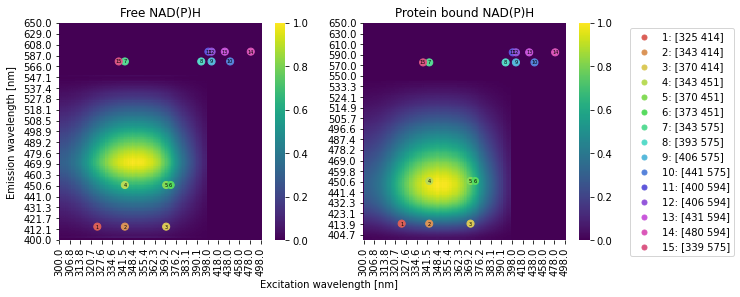

In [11]:
name = 'matrix_combination2.png'
mols = ['Free NAD(P)H', 'Protein bound NAD(P)H']
plot_combination(mols, dfs_new, wls, name=name)

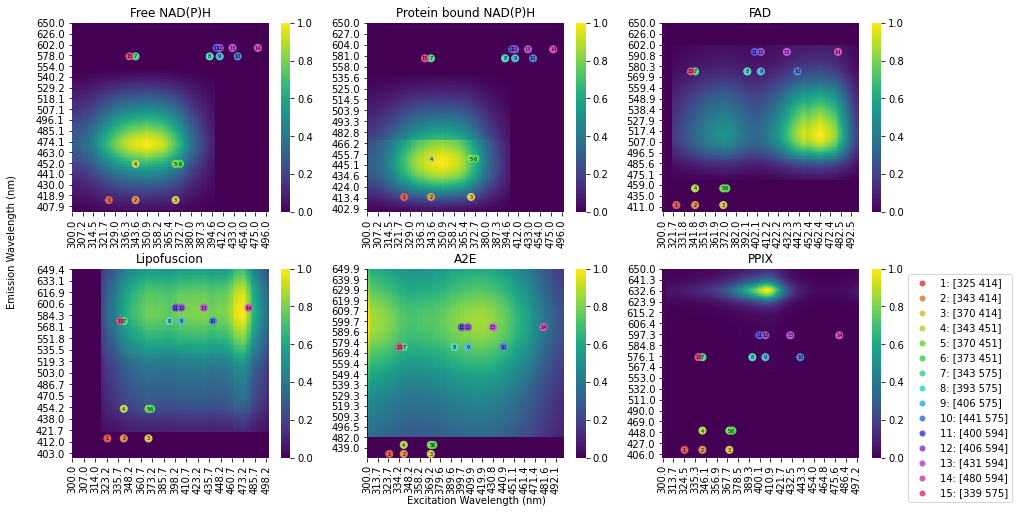

In [94]:
name = 'matrix_combination.png'
plot_combination(mols, dfs_new, wls, name=name)

# validation other papers

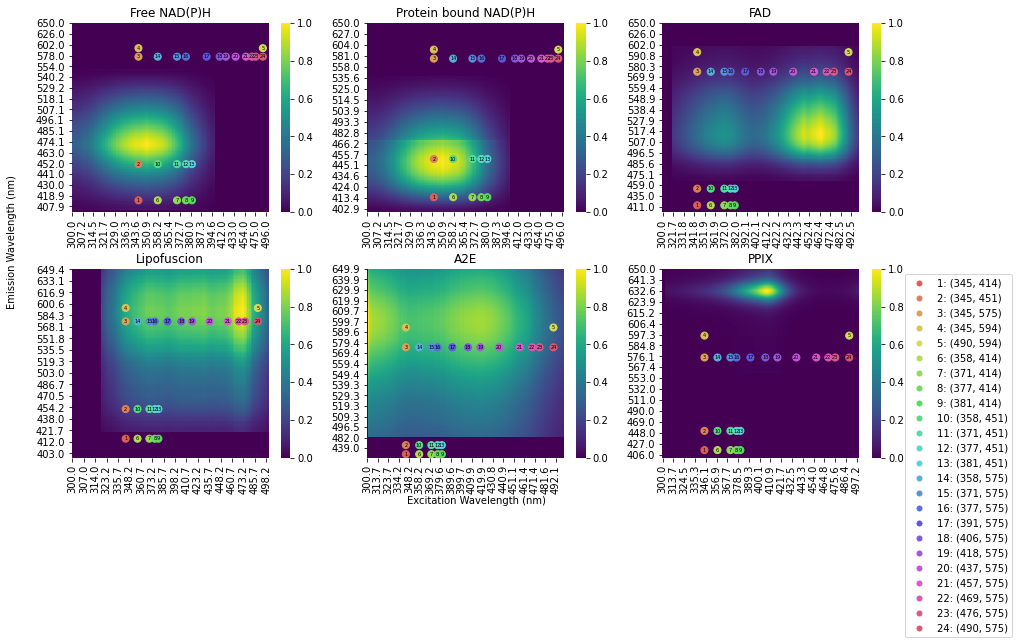

In [19]:
# https://doi.org/10.1007/s10522-022-09957-y
# FAD has an excitation maximum at 450 nm with its emission maxima at 535 nm
# but he studied FAD & NADPH & Collagen
with open('paper1.txt') as f:
    wls2 = f.read()
    
wls2 = [(int((i.split('/')[0].replace(' ', ''))), int((i.split('/')[1].replace(' ', '')))) 
        for i in wls2.split(',')]

wls2.pop(-1)
wls2.pop(5)

plot_combination(mols, dfs_new, wls2, name=False)

In [5]:
[wl[1] - wl[0] for wl in wls2]

[69,
 106,
 230,
 249,
 104,
 89,
 56,
 43,
 37,
 33,
 93,
 80,
 74,
 70,
 217,
 204,
 198,
 184,
 169,
 157,
 138,
 118,
 106,
 99,
 85,
 70]

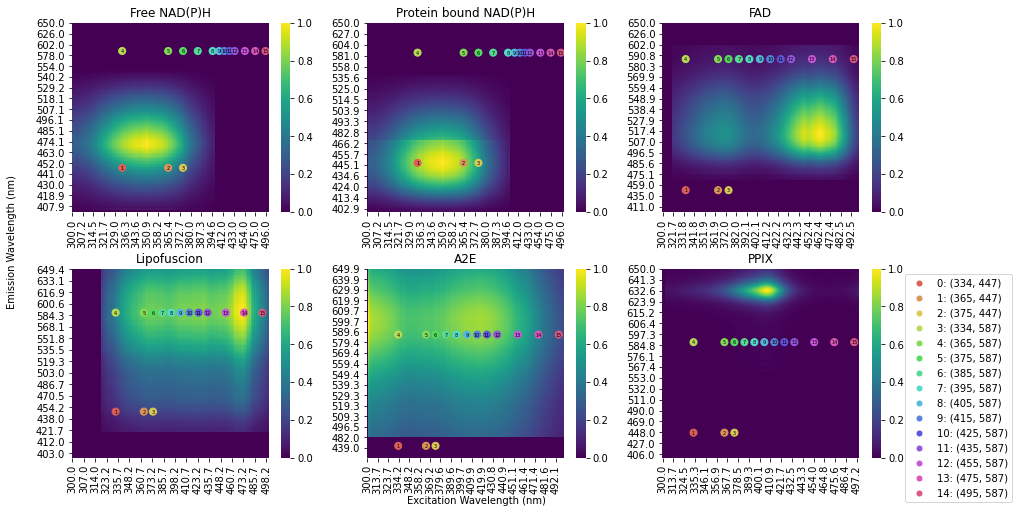

In [65]:
# https://doi.org/10.1364/BOE.8.001488
# Free and bound NADPH
wls3 = [
    (334, 447),
    (365, 447),
    (375, 447),
    (334, 587),
    (365, 587),
    (375, 587),
    (385, 587),
    (395, 587),
    (405, 587),
    (415, 587),
    (425, 587),
    (435, 587),
    (455, 587),
    (475, 587),
    (495, 587),
]

plot_combination(mols, dfs_new, wls3, name=False)

In [7]:
[wl[1] - wl[0] for wl in wls2]

[69,
 106,
 230,
 249,
 104,
 89,
 56,
 43,
 37,
 33,
 93,
 80,
 74,
 70,
 217,
 204,
 198,
 184,
 169,
 157,
 138,
 118,
 106,
 99,
 85,
 70]

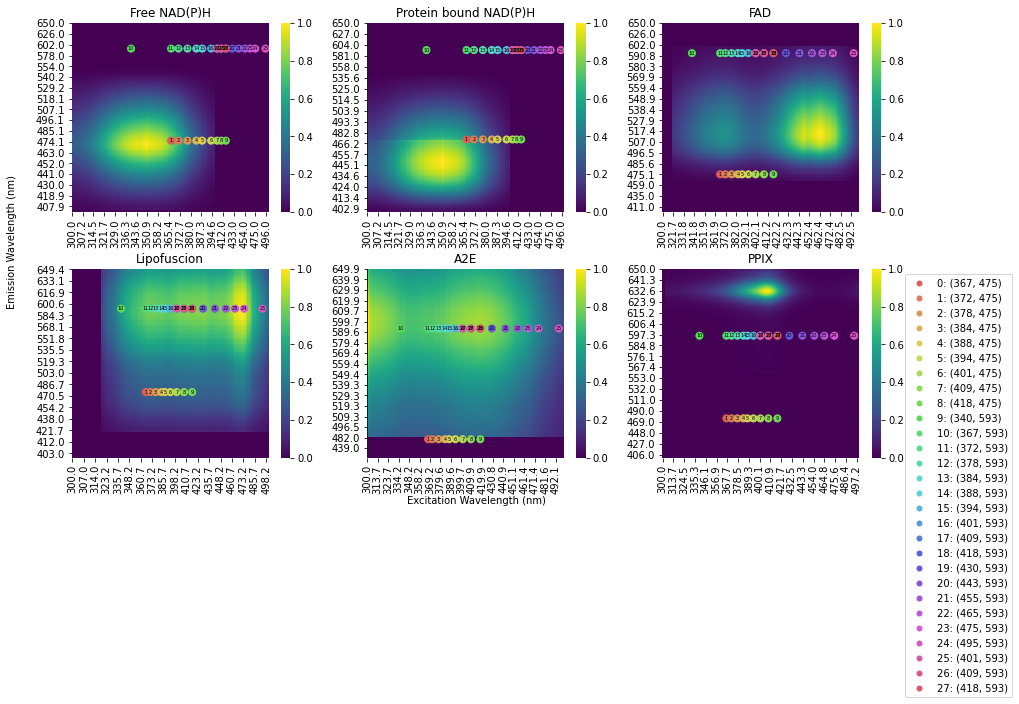

In [83]:
# https://doi.org/10.1093/humrep/deab233
# NADPH and flavins
wls4 = pd.read_excel('deab233_supplementary_table_s2.xlsx')
wls4 = [(i, j) for i, j in zip(wls4['ex'].tolist(), wls4['em'].tolist()) 
        if (300 <= i <= 500) & (400 <= j <= 650)]

plot_combination(mols, dfs_new, wls4, name=False)

In [9]:
[wl[1] - wl[0] for wl in wls4]

[108,
 103,
 97,
 91,
 87,
 81,
 74,
 66,
 57,
 253,
 226,
 221,
 215,
 209,
 205,
 199,
 192,
 184,
 175,
 163,
 150,
 138,
 128,
 118,
 98,
 192,
 184,
 175]